Original code from Holly and Scott,
Modified to Jupyter notebook and error corrections by FSL

"""

@authors: Holly Wilson, Scott Wellington
@email: sdlw20@bath.ac.uk

"Improving inner speech decoding by hybridisation of bimodal EEG and fMRI data"
in proceedings of the 46th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC)
(2024) [in print; publication forthcoming].

"""

In [1]:
import os
import copy
import pandas as pd
import numpy as np
np.random.seed(42)
import seaborn as sns
import matplotlib.pyplot as plt
import mne
import nibabel as nib
from operator import itemgetter

from nilearn.input_data import NiftiMasker
from nilearn.image import index_img, concat_imgs

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, SelectPercentile, VarianceThreshold
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding

In [2]:
def load_labels(subject,session):
    """
    # load the labels for beta files
    Parameters
    ----------
    subject : string
        refers to the participant number.
    session : string
        refers to the session, will have the value of 1 or 2.

    Returns
    -------
    labels : list of strings
        all the labels for the trials in the correct order

    """
    # load the labels for beta files
    iSpeech = os.path.abspath(os.getcwd()) # this dir
    iSpeech_proc = os.path.join(iSpeech, 'iSpeech_proc')
    fmripath = os.path.join(iSpeech_proc,'fMRI-proc')
    txtFile = os.path.join(fmripath, 'labels') # FSL correction
    #txtFile = os.path.join(txtFile,'beta_labels_subject'+subject+'_session'+session+'.txt')
    txtFile = os.path.join(txtFile,'single_condition_subject'+subject+'_session'+session+'.txt') # FSL correction
    txtFile = os.path.join(os.path.dirname(os.getcwd()), txtFile)
    data = pd.read_fwf(txtFile,header=None)
    data.columns = ['label', 'beta_file' , 'duration'] ## FSL
    filtered =[]
    for i in data['label']:
        filtered.append("".join(filter(str.isalpha,i)))
    data['label'] = filtered
    labels = data['label']
    return labels

In [3]:
def load_fmri(subject, session, mni_space=bool):
    """
    loads up the beta images from the the file path as one volume
    extracts just the first 160 slices, as some ppts have an extra couple of images.


    Parameters
    ----------
    subject : string
        a value of 1,2,3 or 5.
    session : string
        a value of 1 or 2.

    Returns
    -------
    epi_img_data : Nifti data object
        DESCRIPTION.

    """
    # load fmri data
    trial_num = 160 # should be constant across subjects and sessions
    print("loading up brain for subject and session ", subject, session)
    iSpeech = os.path.abspath(os.getcwd()) # this dir
    iSpeech_proc = os.path.join(iSpeech, 'iSpeech_proc')
    fmripath = os.path.join(iSpeech_proc,'fMRI-proc','sub-0'+subject)
    if mni_space == True:
        print("In MNI space")
        fmripath = os.path.join(fmripath,'single_trial_sess'+session)
    elif mni_space == False:
        print("In native space")
        fmripath = os.path.join(fmripath,'single_trial_sess'+session+'_native')
    beta_file = os.path.join(fmripath, 'sub'+subject+'_sess'+session+'_betas_4D.nii')
    print("Beta file is ", beta_file)
    epi_img_data = index_img(beta_file, slice(0, trial_num))
    print("shape of the fMRI data is ", epi_img_data.shape)
    return epi_img_data

In [4]:
def separate_or_combine_session(sessions, sess1_labels = None, sess1_fmri= None, sess2_labels= None,sess2_fmri= None ):
    if sessions =='combine':
        try:
            epi_img_data = concat_imgs([sess1_fmri,fixed_second_img])
        except:
            fixed_second_img = nib.Nifti1Image(sess2_fmri.get_fdata(), sess1_fmri.affine, header=sess1_fmri.header)
            epi_img_data = concat_imgs([sess1_fmri,fixed_second_img])
        labels = pd.concat([sess1_labels, sess2_labels])
    elif sessions == 'first':
        epi_img_data = sess1_fmri
        labels = sess1_labels
    elif sessions =='second':
        epi_img_data = sess2_fmri
        labels = sess2_labels
    return epi_img_data, labels

In [5]:
def fetch_subject(subject, mni_space=bool):

    print("Working with individual subject's data")
    s1l = load_labels(subject, '1')
    s1f = load_fmri(subject, '1', mni_space=mni_space)
    s2l = load_labels(subject, '2')
    s2f = load_fmri(subject, '2', mni_space=mni_space)
    epi, lab = separate_or_combine_session(sessions = session,sess1_labels=s1l,sess1_fmri=s1f, sess2_labels=s2l,sess2_fmri=s2f)
    print(epi)
    return epi, lab

In [6]:
def make_binary(labels):
    # split labels into binary
    for i in range(len(labels)):
     #   print(labels[i])
        if labels[i] in ['four','ten','six','three']:
         #   print("number")
            labels[i] = 'number'
        elif labels[i] in ['daughter', 'father', 'wife', 'child', 'aughter']:
            labels[i] = 'social'
    return labels

In [7]:
def check_masking_strategy(mask_strategy, epi_img_data=None):
    masker = NiftiMasker(mask_strategy=mask_strategy)
    masker.fit(epi_img_data)
    report = masker.generate_report()
    report.open_in_browser()

In [8]:
def array_transform(x):
    print(x[0])
    return np.array([transform(xi) for xi in x])

In [9]:
def augment_duplicate(data, labels, repeats = 8):
    """
    Function to create random pairings between EEG and fMRI with shared labels.
    """

    new_data = np.repeat(data, repeats, axis=0)
    new_data_df = pd.DataFrame(new_data)
    new_labels = np.repeat(labels, repeats, axis=0)
    new_labels_df = pd.DataFrame(new_labels)

    new_data_df['order'] = new_labels
    new_labels_df['order'] = new_labels

    new_labels_df = shuffle(new_labels_df)
    new_labels_df = new_labels_df.reset_index(drop=True)
    new_data_df = shuffle(new_data_df)
    new_data_df = new_data_df.reset_index(drop=True)

    # make into two data frames, shuffle, then sort them using same ordering
    new_data_df =  new_data_df.sort_values(by=['order'])
    new_labels_df= new_labels_df.sort_values(by=['order'])
    new_data_df = new_data_df.drop(columns=['order'])
    new_labels_df = new_labels_df.drop(columns=['order'])
    new_labels_df = new_labels_df.reset_index(drop=True)
    new_data_df = new_data_df.reset_index(drop=True)

    return new_data_df.to_numpy(), new_labels_df.to_numpy().ravel()

In [33]:
""" LATE FUSION METHOD USED IN PAPER - FSL"""
def ensemble_approach(eeg, fmri, y, cv=4, subject=None):
    """
    Train two separate models for EEG and fMRI data. These output
    probability vectors which are then concatenated and fed into
    a new joint model. The joint model is tested on unseen data.
    """
    overall_joint_score = []
    overall_eeg_score = []
    overall_fmri_score = []
    F1 = []

    # Shuffle data once and take test and train splits based on indices
    random_state = 42
    fmri, eeg, y = shuffle(fmri, eeg, y, random_state=random_state)

    # Use StratifiedKFold for cross-validation
    kf = StratifiedKFold(n_splits=cv, random_state=random_state, shuffle=True)
    le = LabelEncoder()
    y = le.fit_transform(y)

    for train_index, test_index in kf.split(eeg, y):
        scaler = Normalizer(norm='l2')
        print("Indexes are", train_index, test_index)

        # Split the EEG and fMRI data using the indices provided by KFold
        eegX_train, eegX_test = eeg[train_index], eeg[test_index]
        fmriX_train, fmriX_test = fmri[train_index], fmri[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # L2 normalize the EEG data
        eegX_train = scaler.fit_transform(np.reshape(eegX_train, (eegX_train.shape[0], -1)))
        eegX_test = scaler.fit_transform(np.reshape(eegX_test, (eegX_test.shape[0], -1)))

        # Make pipelines for EEG and fMRI
        eeg_feature_selection = SelectPercentile(f_classif, percentile=2)
        fmri_feature_selection = SelectPercentile(f_classif, percentile=1)
        fmri_extraction = LinearDiscriminantAnalysis(n_components=1)

        eeg_clf_percentile = make_pipeline(StandardScaler(), eeg_feature_selection,
                                           RandomForestClassifier(n_estimators=100, random_state=random_state))
        fmri_clf_percentile = make_pipeline(StandardScaler(), fmri_feature_selection,
                                            SVC(probability=True, kernel='linear', C=64, random_state=random_state))
        joint_clf_percentile = make_pipeline(LinearSVC(random_state=random_state))

        # Train *fMRI* and *EEG* models separately, then get predictions on test set
        eeg_model = eeg_clf_percentile.fit(eegX_train, y_train)
        eeg_scores = eeg_model.score(eegX_test, y_test)
        overall_eeg_score.append(eeg_scores)
        print("The eeg scores are", eeg_scores)

        fmri_model = fmri_clf_percentile.fit(fmriX_train, y_train)
        fmri_scores = fmri_model.score(fmriX_test, y_test)
        overall_fmri_score.append(fmri_scores)
        print("The fmri scores are", fmri_scores)

        # Get probability predictions from both models
        train_eeg_prob_predictions = eeg_model.predict_proba(eegX_train)
        train_fmri_prob_predictions = fmri_model.predict_proba(fmriX_train)

        # Weight the probability predictions based on the model scores
        eeg_scores = max(0, (eeg_scores - 0.125))
        fmri_scores = max(0, (fmri_scores - 0.125))
        train_eeg_prob_predictions = train_eeg_prob_predictions * eeg_scores
        train_fmri_prob_predictions = train_fmri_prob_predictions * fmri_scores

        # Concatenate probability predictions
        joint_prob_predictions_train = np.concatenate((train_eeg_prob_predictions, train_fmri_prob_predictions), axis=1)
        joint_model = joint_clf_percentile.fit(joint_prob_predictions_train, y_train)

        # Test on the test set
        test_eeg_prob_predictions = eeg_model.predict_proba(eegX_test)
        test_fmri_prob_predictions = fmri_model.predict_proba(fmriX_test)
        joint_prob_predictions_test = np.concatenate((test_eeg_prob_predictions, test_fmri_prob_predictions), axis=1)

        # Evaluate the joint model
        predicted_labels = joint_model.predict(joint_prob_predictions_test)
        F1.append(f1_score(predicted_labels, y_test, average='macro'))
        scores = joint_model.score(joint_prob_predictions_test, y_test)
        overall_joint_score.append(scores)
        print("The joint scores are", scores)

    print(f"For subject {subject}: The overall joint score is mean:", np.mean(overall_joint_score), ", sd: ", np.std(overall_joint_score))
    print(f"For subject {subject}: The overall eeg score is mean:", np.mean(overall_eeg_score), ", sd: ", np.std(overall_eeg_score))
    print(f"For subject {subject}: The overall fmri score is mean:", np.mean(overall_fmri_score), ", sd: ", np.std(overall_fmri_score))


In [11]:
def early_fusion(eeg, fmri, y, kernel='linear', svc_c=0.1,augment = False, cv=5):
    """
    extension of grid_search_early_fusion()
    """

    accuracies = []
    F1 = []
    # takes top one percentile of discriminative features using ANOVA
    extraction = LocallyLinearEmbedding(n_components=10)
    feature_selection = SelectPercentile(f_classif, percentile=1)
    clf_percentile = make_pipeline( StandardScaler(), feature_selection, SVC(kernel = kernel, C=svc_c, random_state=42))
    le =  LabelEncoder()

    y = le.fit_transform(eeg_labels)

    eeg, fmri, y, = shuffle(eeg, fmri, y, random_state = 42)

    # k-fold train test split
    kf = StratifiedKFold(n_splits=cv, random_state=None)
    for train_index, test_index in kf.split(eeg, y):

        eeg_X_train, eeg_X_test = eeg[train_index], eeg[test_index]
        fmri_X_train, fmri_X_test = fmri[train_index], fmri[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Augment via random pairing of eeg and fMRI - this is done separately within test and train to avoid data leakage
        if augment == True:
            r = 15 #repetitions
            fmri_X_train, yi = augment_duplicate(fmri_X_train, y_train, repeats = r)
            fmri_X_test, yi = augment_duplicate(fmri_X_test, y_test, repeats = r)
            eeg_X_train, y_train = augment_duplicate(eeg_X_train, y_train, repeats = r)
            eeg_X_test, y_test = augment_duplicate(eeg_X_test, y_test,
                repeats = r)
            print("Shapes of augmented data are ", len(y_train), len(fmri_X_train))

        # Fuse data together
        joint_train = np.hstack((eeg_X_train, fmri_X_train))
        joint_test = np.hstack((eeg_X_test, fmri_X_test))

        model = clf_percentile.fit(joint_train, y_train)
        test_predictions = model.predict(joint_test)
        F1.append(f1_score(test_predictions, y_test, average = 'macro'))
        scores = model.score(joint_test, y_test)
        print(scores)
        accuracies.append(scores)

    print("Subject ", subject, ": the overall accuracy is ", np.mean(accuracies), np.std(accuracies), np.mean(F1))

    results = "\n" + "for kernel " + kernel + " and C " + str(svc_c) +  " the acc, std and f1 are :" +  str(np.mean(accuracies)) + " " + str(np.std(accuracies))+ " "+ str(np.mean(F1)) + "\n"
    print(results)
    print("Accuracies are ", accuracies)
    return np.mean(accuracies), np.std(accuracies), np.mean(F1)

In [12]:
""" EARLY FUSION METHOD USED IN PAPER"""
def grid_search_early_fusion(eeg, fmri, y, cv=5, augment=False):

    svc_kernel = ['linear'] # ['rbf','poly']
    svc_c = [2 ** exponent for exponent in range(-7, 8)]

    for kernel in svc_kernel:
        for C in svc_c:
            print(kernel, " " ,C)
            acc, std, f1 = early_fusion(eeg, fmri, y, kernel = kernel, svc_c = C, augment=augment, cv=cv)
            results = "\n" + "Grid search, for kernel " + kernel + " and C " + str(C) +  " the acc, std and f1 are :" +  str(acc) + " " + str(std)+ " "+ str(f1) + "\n"
            print(results)

In [13]:

#if __name__ == "__main__":

"""
    ~~~ MODEL PARAMETERS ~~~

    For our paper [top], we identify the following best-performing model parameters for EEG,
    following exhaustive grid-seach of hyperparameters for SVM and Random Forest, and 10-fold
    cross-validation. Best-performing model parameters for fMRI are static for all participants.

    Subject 1: 1 Hz high-pass filter only (1 Hz to 128 Hz). SVM, linear kernel, C = 0.1
    Subject 2: filtered to theta band (4 Hz to 8 Hz). Random Forest, n_estimators = 100
    Subject 3: filtered to delta band (1 Hz to 4 Hz). Random Forest, n_estimators = 100
    Subject 5: filtered to theta band (4 Hz to 8 Hz). Random Forest, n_estimators = 100

    Choice of frequency subband for EEG was revealed to be an important effector for model
    performances between subjects. Underlying structure of the data [see below] provides a visual
    example of this phenomena [see also the paper]. Choice of model (SVM or RF) was revealed
    to be minimally impactful (model accuracies  ~1% difference). Researchers are invited to
    experiment with models, parameters and subband frequencies, and especially explore the use
    of deep neural networks, as this was under-explored in this work [see paper conclusions].

"""

# Configurable parameters:

subject = '1'  # subject number: 1, 2, 3 or 5 (subject 5==4 in the paper)
plot_structure = False
random_state=42

# Non-Configurable parameters:

session = 'combine'  # can be 'combine', 'first', or 'second'
binary = False  #  8-class words, or binary social vs. number
check_mask = False  # produce html with mask overlapped on beta image
mni_space = True  # either normalised to mni space, or in native space
# NOTE that, in this work, we use native space. MNI space fMRI data is not calculated.
if mni_space == True:
    mask_strategy = 'whole-brain-template'  # epi is not appropriate to use for beta images
elif mni_space == False:
    mask_strategy = 'background'
#TR = 2160 # ms # IGNORE (fMRI; hardcoded)


In [14]:

"""  [1]   LOAD AND PROCESS fMRI DATA AND LABELS """

masker = NiftiMasker(mask_strategy=mask_strategy, smoothing_fwhm=5)

epi_img_data, fmri_labels = fetch_subject(subject, mni_space=mni_space)
print("Shape of fMRI data ", epi_img_data.shape, len(fmri_labels))

# Hotfix, because some of the trials are incorrectly labelled as 'aughter'
fmri_labels = fmri_labels.to_list()
for i in range(len(fmri_labels)):
    if fmri_labels[i] == 'aughter':
        fmri_labels[i] = 'daughter'

if binary == True:
    # can either categorise each of the 8 words separately, or split into the two semantic categories
    fmri_labels = make_binary(fmri_labels)
if check_mask == True:
    # run visualisation make sure that background mask on fMRI data looks as expected
    check_masking_strategy(mask_strategy, epi_img_data=epi_img_data)

# Apply mask to the data
epi_img_data = masker.fit_transform(epi_img_data)
print("Shape of fMRI data after masking ", epi_img_data.shape)

# Apply VarianceThreshold to remove constant features in fMRI and EEG data
variance_threshold = VarianceThreshold(threshold=0)  # Removes constant features

# Fit and transform the fMRI data
epi_img_data = variance_threshold.fit_transform(epi_img_data)
print("Shape of fMRI data after removing constant features:", epi_img_data.shape)


# Sort the fMRI data by labels so it can be matched with the EEG data
fmri_labels, epi_img_data = map(list, zip(*sorted(zip(fmri_labels, epi_img_data), reverse=True, key=itemgetter(0))))
print("fMRI labels are as follows ", fmri_labels)


Working with individual subject's data
loading up brain for subject and session  1 1
In MNI space
Beta file is  /Users/fotsim/Documents/iSpeech-FSL/iSpeech_proc/fMRI-proc/sub-01/single_trial_sess1/sub1_sess1_betas_4D.nii
shape of the fMRI data is  (79, 95, 79, 160)
loading up brain for subject and session  1 2
In MNI space
Beta file is  /Users/fotsim/Documents/iSpeech-FSL/iSpeech_proc/fMRI-proc/sub-01/single_trial_sess2/sub1_sess2_betas_4D.nii
shape of the fMRI data is  (79, 95, 79, 160)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (79, 95, 79, 320)
affine:
[[  -2.    0.    0.   78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -70.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  4  79  95  79 320   1   1   1]
intent_p1       : 0.0


In [17]:
"""  [2]   LOAD AND PROCESS EEG DATA AND LABELS """

iSpeech = os.path.abspath(os.getcwd())  # this dir
iSpeech_proc = os.path.join(iSpeech, 'iSpeech_proc')
eeg_path = os.path.join(iSpeech_proc, 'EEG-proc')
eeg_path = os.path.join(eeg_path, 'epoched')
eeg_path = os.path.join(eeg_path, 'subject0' + subject + '_eeg-epo.fif.gz')
eeg_epochs = mne.read_epochs(eeg_path)
eeg_epochs = eeg_epochs.crop(tmin=-0.2, tmax=0.8)
eeg_events = mne.read_events(eeg_path)
print("EEG labels are as follows ", eeg_epochs.event_id)
eeg_labels = eeg_epochs.events[:, -1].tolist()
eeg_data = eeg_epochs.get_data()
print("Shape of EEG is, ", eeg_data.shape)
for i in range(len(eeg_labels)):
    our = [k for k in eeg_epochs.event_id if eeg_epochs.event_id[k] == eeg_labels[i]]
    eeg_labels[i] = our[0]
if binary == True:
    eeg_labels = make_binary(eeg_labels)

# Organise EEG data by labels so it can be mapped onto fMRI data
eeg_labels, eeg_data = map(list, zip(*sorted(zip(eeg_labels, eeg_data), reverse=True, key=itemgetter(0))))
print(eeg_labels)
if subject == '5':  # needs to be the same length as fMRI, but subject 5 has an extra EEG trial
    del eeg_data[139]  #extra sixth trial
    del eeg_labels[139]  #extra sixth trial
eeg_data = np.array(eeg_data)
epi_img_data = np.array(epi_img_data)
eeg_data = np.reshape(eeg_data, (eeg_data.shape[0], eeg_data.shape[1] * eeg_data.shape[2]))
print("Shape of EEG data ", eeg_data.shape)
# Apply VarianceThreshold to remove constant features in fMRI and EEG data
variance_threshold = VarianceThreshold(threshold=0)  # Removes constant features
# Apply VarianceThreshold to EEG data
eeg_data = variance_threshold.fit_transform(eeg_data)
print("Shape of EEG data after removing constant features:", eeg_data.shape)

Reading /Users/fotsim/Documents/iSpeech-FSL/iSpeech_proc/EEG-proc/epoched/subject01_eeg-epo.fif.gz ...
    Found the data of interest:
        t =    -199.22 ...    2498.05 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
320 matching events found
No baseline correction applied
0 projection items activated


/var/folders/ld/ylxrkm9n11v7ksyq1103_t140000gn/T/ipykernel_69064/2328464827.py:9: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.epochs.EpochsFIF'>.tmin (-0.199219 s)
  eeg_epochs = eeg_epochs.crop(tmin=-0.2, tmax=0.8)
/var/folders/ld/ylxrkm9n11v7ksyq1103_t140000gn/T/ipykernel_69064/2328464827.py:10: RuntimeWarning: This filename (/Users/fotsim/Documents/iSpeech-FSL/iSpeech_proc/EEG-proc/epoched/subject01_eeg-epo.fif.gz) does not conform to MNE naming conventions. All events files should end with .eve, -eve.fif, -eve.fif.gz, -eve.lst, -eve.txt, _eve.fif, _eve.fif.gz, _eve.lst, _eve.txt or -annot.fif
  eeg_events = mne.read_events(eeg_path)


EEG labels are as follows  {'ten': 127, 'wife': 114, 'six': 128, 'father': 113, 'four': 125, 'three': 126, 'child': 111, 'daughter': 112}
Shape of EEG is,  (320, 64, 513)
['wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', '

In [18]:


""" [3]  Combine the EEG and fMRI into bimodal data"""

print("The shape of EEG and fMRI separately are ", eeg_data.shape, epi_img_data.shape)
bimodal_data = np.concatenate((eeg_data, epi_img_data), axis=1)
print("shape of bimodal data ", bimodal_data.shape)
print("Shared labels are ", eeg_labels)

# This checks that the EEG and fMRI have the same ordering of labels
a = set(eeg_labels)
b = set(fmri_labels)
if a == b:
    print("EEG and fMRI labels are equal")
else:
    print("EEG and fMRI labels are not equal")


def most_frequent(List):
    return max(set(List), key=List.count)


print(most_frequent(eeg_labels))

The shape of EEG and fMRI separately are  (320, 32832) (320, 216709)
shape of bimodal data  (320, 249541)
Shared labels are  ['wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'wife', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'three', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten', 'ten'

In [19]:

"""  [4]   TRAIN MODELS AND RUN INFERENCE """

acc, std, f1 = early_fusion(eeg_data, epi_img_data, eeg_labels, kernel='linear', svc_c=0.1, augment=True)




Shapes of augmented data are  3840 3840
0.24895833333333334
Shapes of augmented data are  3840 3840
0.11666666666666667
Shapes of augmented data are  3840 3840
0.20833333333333334
Shapes of augmented data are  3840 3840
0.17604166666666668
Shapes of augmented data are  3840 3840
0.10833333333333334
Subject  1 : the overall accuracy is  0.1716666666666667 0.05361659802088653 0.1663993242918636

for kernel linear and C 0.1 the acc, std and f1 are :0.1716666666666667 0.05361659802088653 0.1663993242918636

Accuracies are  [0.24895833333333334, 0.11666666666666667, 0.20833333333333334, 0.17604166666666668, 0.10833333333333334]


In [20]:
grid_search_early_fusion(eeg_data, epi_img_data, eeg_labels, cv=10, augment=True)

linear   0.0078125
Shapes of augmented data are  4320 4320
0.15
Shapes of augmented data are  4320 4320
0.3020833333333333
Shapes of augmented data are  4320 4320
0.11666666666666667
Shapes of augmented data are  4320 4320
0.20625
Shapes of augmented data are  4320 4320
0.11666666666666667
Shapes of augmented data are  4320 4320
0.2125
Shapes of augmented data are  4320 4320
0.18541666666666667
Shapes of augmented data are  4320 4320
0.18333333333333332
Shapes of augmented data are  4320 4320
0.17916666666666667
Shapes of augmented data are  4320 4320
0.10416666666666667
Subject  1 : the overall accuracy is  0.175625 0.055832167276380885 0.16445690869556467

for kernel linear and C 0.0078125 the acc, std and f1 are :0.175625 0.055832167276380885 0.16445690869556467

Accuracies are  [0.15, 0.3020833333333333, 0.11666666666666667, 0.20625, 0.11666666666666667, 0.2125, 0.18541666666666667, 0.18333333333333332, 0.17916666666666667, 0.10416666666666667]

Grid search, for kernel linear and C

In [ ]:
ensemble_approach(eeg_data, epi_img_data, eeg_labels, cv=10, subject=subject)

Indexes are [  0   1   2   3   4   5   6   7   8  10  11  12  13  14  16  17  18  19
  20  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  48  49  50  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 115
 117 118 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 150 151 152 153 154
 155 156 157 158 159 160 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 180 181 184 185 187 189 190 191 192 193 194 195 196
 197 198 199 200 202 203 204 206 207 209 210 211 213 214 215 216 217 218
 219 221 222 223 225 226 227 228 229 230 231 232 233 234 235 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 267 268 269 270 27

L2 norm: 0.03656916829008363


/var/folders/ld/ylxrkm9n11v7ksyq1103_t140000gn/T/ipykernel_69064/3542882111.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coordinates_i = np.array([[df_social.iloc[i][0], df_social.iloc[i][1]] for i in range(len(df_social))])
/var/folders/ld/ylxrkm9n11v7ksyq1103_t140000gn/T/ipykernel_69064/3542882111.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coordinates_j = np.array([[df_number.iloc[i][0], df_number.iloc[i][1]] for i in range(len(df_number))])


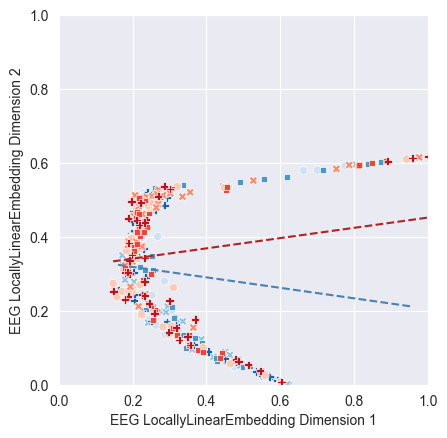

In [32]:
"""  [5]   OPTIONALLY PLOT PPROJECTED DATA STRUCTURE """
#plot_structure = True

if plot_structure:

    data_type = 'EEG'  # can be 'EEG' or 'fMRI'
    manifold_type = 'LocallyLinearEmbedding'

    from sklearn.manifold import LocallyLinearEmbedding
    from dictances import euclidean
    from sklearn.neighbors import KernelDensity
    from scipy.stats import entropy

    if data_type == 'EEG':
        data, labels = eeg_data, eeg_labels  # from above: they're the same order for both fMRI and EEG
        data = StandardScaler().fit_transform(data, labels)
        data = SelectPercentile(f_classif, percentile=2).fit_transform(data, labels)
    elif data_type == 'fMRI':
        data, labels = epi_img_data, eeg_labels  # from above: they're the same order for both fMRI and EEG
        data = StandardScaler().fit_transform(data, labels)
        data = SelectPercentile(f_classif, percentile=1).fit_transform(data, labels)
    else:
        print("Variable `data_type` must be either 'EEG' or 'fMRI'")
        exit()

    # Step 1: Reduce dimensionality using PCA
    manifold = eval(manifold_type)(n_components=2)
    data_reduced = manifold.fit_transform(data)

    df = data_reduced
    df = (df - df.min()) / (df.max() - df.min())

    # Step 2: Create a DataFrame for easy plotting
    df = pd.DataFrame(data=np.column_stack((df, labels)), columns=['PC1', 'PC2', 'Class'])

    df['PC1'] = [float(i) for i in df['PC1']]
    df['PC2'] = [float(i) for i in df['PC2']]

    df_social = df.loc[df['Class'].isin(['daughter', 'wife', 'child', 'father'])]
    df_number = df.loc[df['Class'].isin(['four', 'six', 'three', 'ten'])]

    _df_social = copy.deepcopy(df_social)
    _df_social['PC1'] = df_social['PC2']
    _df_social['PC2'] = df_social['PC1']

    _df_number = copy.deepcopy(df_number)
    _df_number['PC1'] = df_number['PC2']
    _df_number['PC2'] = df_number['PC1']

    df_social = _df_social
    df_number = _df_number

    A_coords = np.array([np.unique(df_social['PC1']),
                         np.poly1d(np.polyfit(df_social['PC1'], df_social['PC2'], 1))(np.unique(df_social['PC1']))])
    B_coords = np.array([np.unique(df_number['PC1']),
                         np.poly1d(np.polyfit(df_number['PC1'], df_number['PC2'], 1))(np.unique(df_number['PC1']))])


    # Function to estimate the PDF using KDE
    def estimate_pdf(coordinates):
        kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
        kde.fit(coordinates)
        return np.exp(kde.score_samples(coordinates))


    # Assuming Xi, Yi and Xj, Yj are your two sets of coordinates, concatenate the coordinates into 2D arrays
    coordinates_i = np.array([[df_social.iloc[i][0], df_social.iloc[i][1]] for i in range(len(df_social))])
    coordinates_j = np.array([[df_number.iloc[i][0], df_number.iloc[i][1]] for i in range(len(df_number))])

    # Estimate PDFs for both sets of coordinates
    pdf_i = estimate_pdf(coordinates_i)
    pdf_j = estimate_pdf(coordinates_j)

    # Normalize the PDFs to ensure they are proper probability distributions
    pdf_i /= np.sum(pdf_i)
    pdf_j /= np.sum(pdf_j)

    # Calculate KL divergence between the two PDFs
    kl_divergence = entropy(pdf_i, pdf_j)

    df_social_dict = {f"event_{i}": pdf_i[i] for i in range(len(pdf_i))}
    df_number_dict = {f"event_{i}": pdf_j[i] for i in range(len(pdf_j))}

    print("L2 norm:", euclidean(df_social_dict, df_number_dict))

    show_legend = False

    # Step 3: Plot the scatter plot
    fig, ax = plt.subplots()
    sns.scatterplot(x='PC1', y='PC2', data=df_social, hue='Class', palette='Blues', style='Class')
    sns.scatterplot(x='PC1', y='PC2', data=df_number, hue='Class', palette='Reds', style='Class')
    plt.plot(np.unique(df_social['PC1']),
             np.poly1d(np.polyfit(df_social['PC1'], df_social['PC2'], 1))(np.unique(df_social['PC1'])),
             color='steelblue', linestyle='dashed')
    plt.plot(np.unique(df_number['PC1']),
             np.poly1d(np.polyfit(df_number['PC1'], df_number['PC2'], 1))(np.unique(df_number['PC1'])),
             color='firebrick', linestyle='dashed')
    plt.title('Distribution of Data with Isomap')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.legend().set_title('')
    ax.legend(labelspacing=0.1)
    ax.set_title('')
    ax.set_xlabel(f'{data_type} {manifold_type} Dimension 1')
    ax.set_ylabel(f'{data_type} {manifold_type} Dimension 2')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    ax.set_aspect('equal', adjustable='box')  # square output
    if not show_legend:
        ax.get_legend().remove()
    plt.show()